In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from fvcore.common.file_io import PathManager
import pycocotools.mask as mask_utils

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

from tqdm import tqdm

In [2]:
DatasetCatalog.clear()
MetadataCatalog.clear()

In [3]:
bb2dfull = True
bb2dvis = False
instance = True
semantic = True
panoptic = False

In [4]:
class_names = ['robot', 'person', 'object']#, 'background'] 
# Get class IDs
class_ids = ['10', '20', '30']#, '0'] 
select_colors = [(0, 80, 142), (0, 161, 28), (0, 242, 171)]#, (0, 0, 0),]

stuff_id = {}
counter = 0
for i in class_ids:
    stuff_id[int(i)] = counter
    counter = counter + 1

print('All dataset class names and their corresponding IDs in labels:')
print('Class Names: ', class_names)
print('Class IDs: ', class_ids)
print('Class Colors: ', len(select_colors))
print(stuff_id)

All dataset class names and their corresponding IDs in labels:
Class Names:  ['robot', 'person', 'object']
Class IDs:  ['10', '20', '30']
Class Colors:  3
{10: 0, 20: 1, 30: 2}


In [5]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [6]:
# Shuffles into train/val dfs and annotates each segmentation instance into Detectron2
path = '/home/danilo/humble_ws/depot_dataset_semantic_nsc_2'
images_dir = os.path.join(path, 'segmentation_data','instance_camera', 'images')
masks_dir = os.path.join(path, 'segmentation_data','instance_camera', 'labels_maps')
bbox_ann_dir = os.path.join(path, 'bounding_box_full_2d_data','boxes')
#bbox_ann_dir = os.path.join(path, 'bounding_box_visible_2d_data','boxes')

image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
bbox_ann_paths = [os.path.join(bbox_ann_dir, image_id) for image_id in sorted(os.listdir(bbox_ann_dir))]
    
paths_df = pd.DataFrame()
paths_df['image_path'] = image_paths
paths_df['mask_path'] = mask_paths
paths_df['bbox_ann_path'] = bbox_ann_paths

# Shuffle DataFrame
paths_df = paths_df.sample(frac=1).reset_index(drop=True)
# Perform 90/10 split for train / val
global_valid_df = paths_df.sample(frac=0.1, random_state=42) #pseudorandom seed
global_train_df = paths_df.drop(global_valid_df.index)
print("Total Images = " + str(len(paths_df)),
len(global_train_df), len(global_valid_df))
   
## Normalize label_maps if needed 
#convert_images('train')
#convert_images('valid')
 
for d in ["train", "valid"]:
    DatasetCatalog.register("simulation_" + d, lambda d=d: load_custom_dataset(str(d)))
    MetadataCatalog.get("simulation_" + d).set(thing_classes=['robot', 'person', 'object'])
simulation_metadata = MetadataCatalog.get("simulation_train")
    

def convert_images(input_df):
    if(input_df == 'train'):
        image_paths = global_train_df['image_path'].tolist()
        mask_paths = global_train_df['mask_path'].tolist()
    else:
        image_paths = global_valid_df['image_path'].tolist()
        mask_paths = global_valid_df['mask_path'].tolist()

    counter = 0
    for image_file, gt_file in zip(image_paths, mask_paths):
        im = np.array(Image.open(gt_file))
        #im[im == 0] = 0
        #im[im == 63] = 1
        #im[im == 98] = 2
        #im[im == 162] = 3
        pil_img_gray = Image.fromarray(im)
        pil_img_gray.save(gt_file)
        
def load_custom_dataset(input_df):
    #print(global_train_df['image_path'].tolist())
    results = []
    if(input_df == 'train'):
        image_paths = global_train_df['image_path'].tolist()
        mask_paths = global_train_df['mask_path'].tolist()
        ann_paths = global_train_df['bbox_ann_path'].tolist()
    else:
        image_paths = global_valid_df['image_path'].tolist()
        mask_paths = global_valid_df['mask_path'].tolist()
        ann_paths = global_valid_df['bbox_ann_path'].tolist()
        
    counter = 0
    for image_file, gt_file , ann_file in tqdm(zip(image_paths, mask_paths, ann_paths)):

        # PIL Image is efficient as it doesn't read image to retrieve size
        im = Image.open(gt_file)
        width, height = im.size
        record = {}
        annotations = {}
        record["file_name"] = image_file
        record["image_id"] = counter
        record["height"] = height
        record["width"] = width
        #ann_df = pd.read_csv(ann_file)
        ann_df = pd.read_csv(ann_file)
        objs = []
        for index, row in ann_df.iterrows():
            # Define the bounding box coordinates (left, upper, width, height)
            bbox = (round(ann_df['x_center'][index]-(0.5*(ann_df['width'][index]))), round(ann_df['y_center'][index]-(0.5*(ann_df['height'][index]))), round(ann_df['width'][index]), round(ann_df['height'][index]))
            #print(bbox)
            # Create an empty binary mask image
            #mask = Image.new('1', im.size)
            other_class = 0
            inst_id_count = []
            dif_ids = []
            final_id = 0
            crowd = 0
            pix_count=0
                        
            # Crop the image to the bbox
            bbox = (bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3])
            #print(bbox)
            img_crop = im.crop(bbox)

            # Convert the cropped image to a numpy array
            img_arr = np.array(img_crop)

            # Find the indices of pixels with the specific RGB value
            b = ann_df['label'][index]
            mask1 = np.all(img_arr == [2, 0, b], axis=-1)
            mask2 = np.all(img_arr == [1, 0, b], axis=-1)
            mask = mask1 | mask2


            # Create a binary mask of the whole image with the found pixels as 1s
            full_mask = np.zeros((600,800), dtype=np.uint8)
            full_mask[bbox[1]:bbox[3], bbox[0]:bbox[2]] = mask.astype(np.uint8) * 255

            # Plot the binary mask
            # Plot the binary mask using matplotlib
            #plt.imshow(full_mask, cmap='gray')
            #plt.show()
            #rle = mask_utils.encode(np.asfortranarray(full_mask))
            #print(rle)
            # Find contours in the binary mask
            contours, _ = cv2.findContours(full_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Convert the contours to polygons in the format of [x1, y1, ..., xn, yn]
            polygons = []
            for contour in contours:
                # Approximate the contour with a polygon
                epsilon = 0.01 * cv2.arcLength(contour, True)
                polygon = cv2.approxPolyDP(contour, epsilon, True)
                # Flatten the list of (x, y) points and convert to floats
                polygon = polygon.flatten().tolist()
                polygon = [float(coord) for coord in polygon]
                if len(polygon) < 8:
                    continue
                assert len(polygon) >= 8
                polygons.append(polygon)

            # Print the resulting polygons
            #print(polygons)

            
             
            obj = {
                "bbox": [round(ann_df['x_center'][index]-(0.5*(ann_df['width'][index]))), round(ann_df['y_center'][index]-(0.5*(ann_df['height'][index]))), round(ann_df['width'][index]), round(ann_df['height'][index])],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": polygons,
                "category_id": (stuff_id[ann_df['label'][index]]),
                "iscrowd": crowd
            }
            objs.append(obj)
        record["annotations"] = objs
        counter = counter + 1
        #print('done with data: ', counter)
        results.append(record)

              
        

    assert len(results),  f"No images found in {image_dir}!"
    #assert PathManager.isfile(results[0]["sem_seg_file_name"]
    #), "Passed"  # noqa

    return results

Total Images = 2613 2352 261


In [7]:
dataset_dicts = load_custom_dataset("train")

2352it [00:39, 59.28it/s]


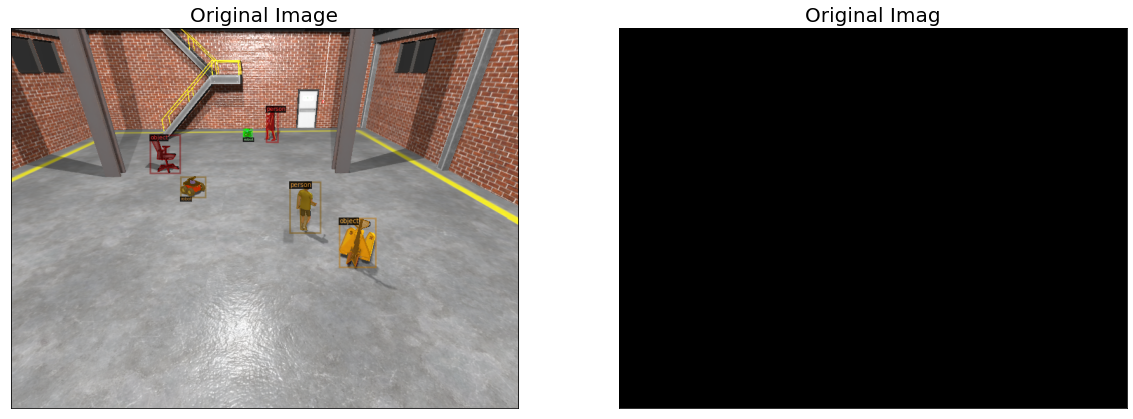

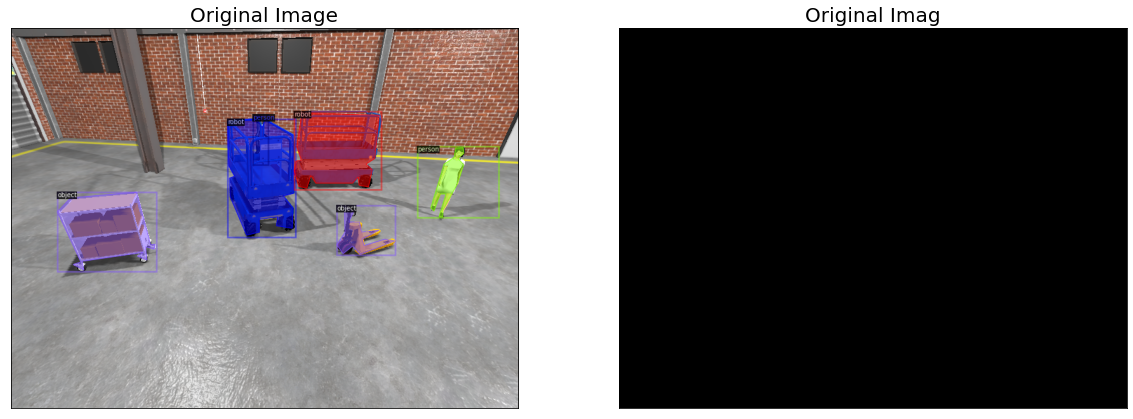

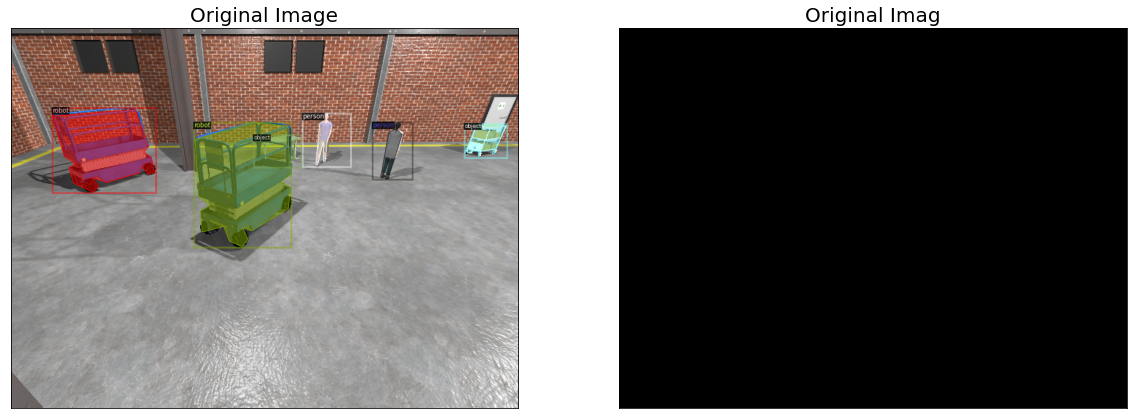

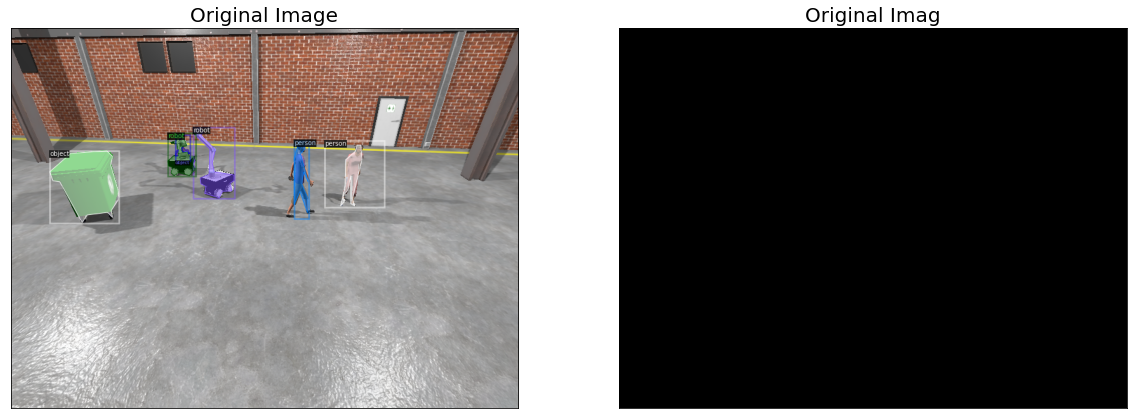

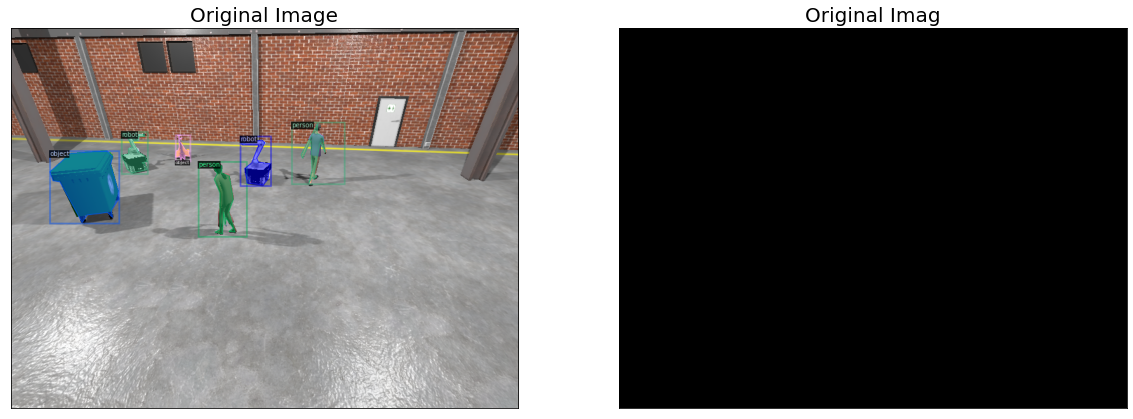

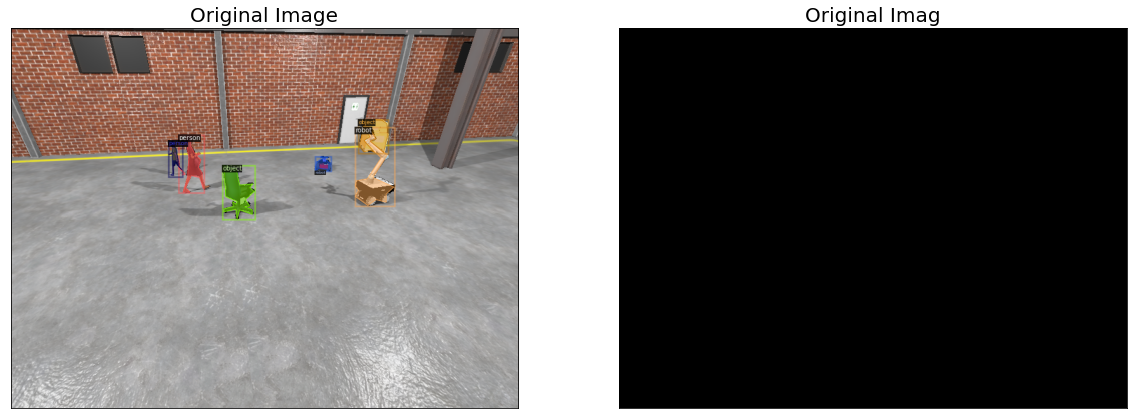

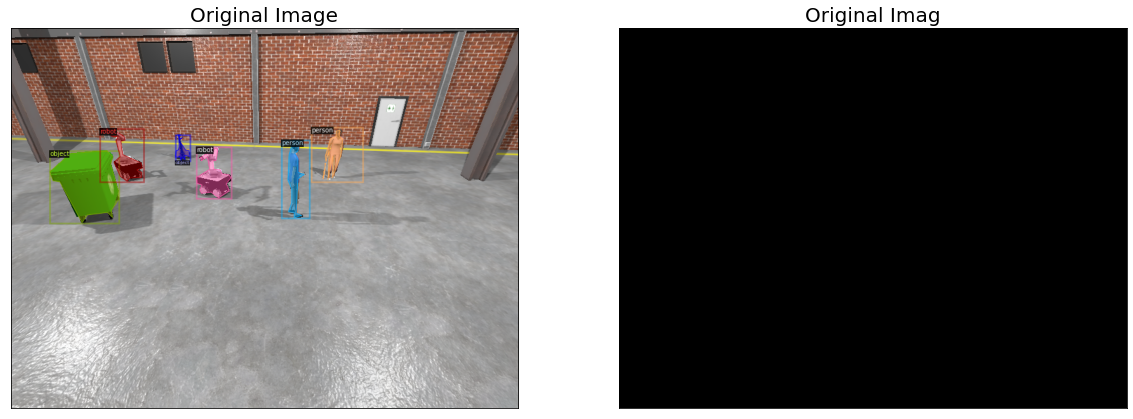

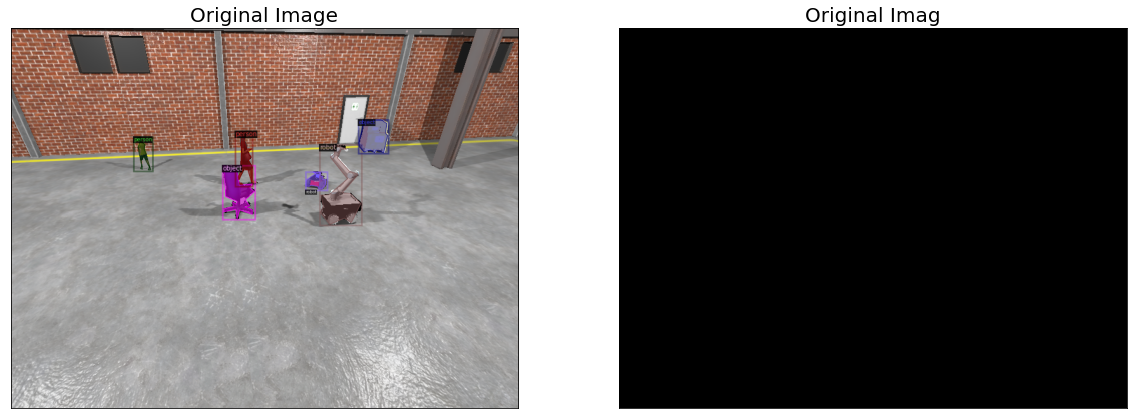

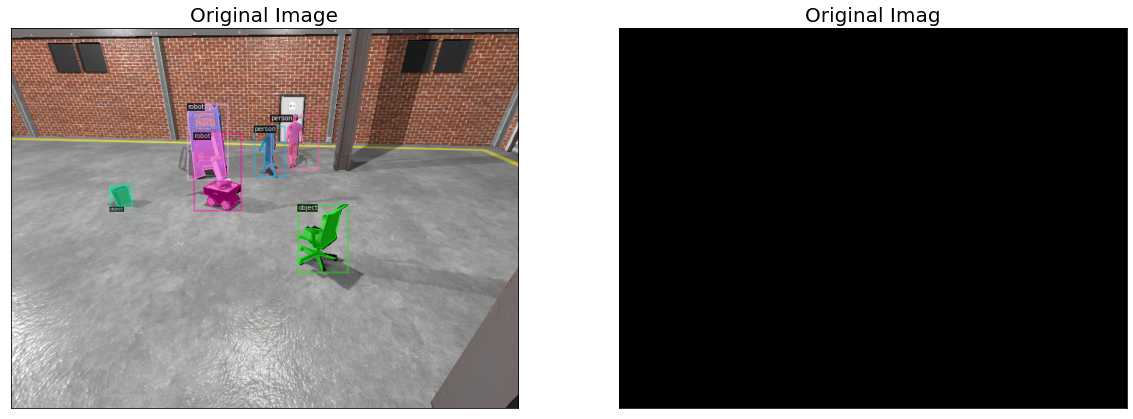

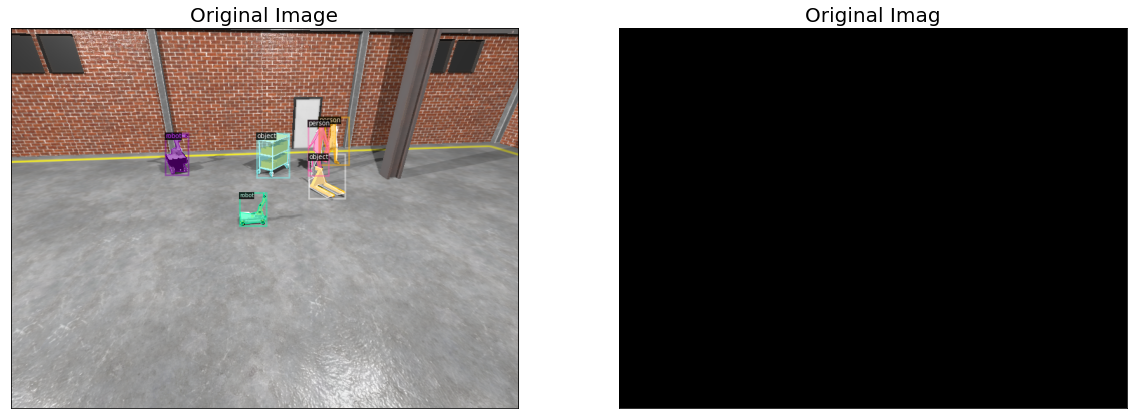

In [8]:
for d in random.sample(dataset_dicts, 10):
    img = cv2.cvtColor(cv2.imread(d["file_name"]),cv2.COLOR_BGR2RGB)
    #mask = cv2.imread(d["sem_seg_file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=simulation_metadata, scale=1, instance_mode=ColorMode.SEGMENTATION)
    out = visualizer.draw_dataset_dict(d)
    
    visualize(
        original_image = out.get_image()[:, :, ::-1],
        original_imag = Image.new('1', (800,600))
    )

In [19]:
!python export_model.py --config-file output/model_cfg.yaml --output .output --sample-image navigation.png --export-method tracing --format torchscript MODEL.WEIGHTS output/model_final.pth MODEL.DEVICE cuda


/home/danilo/anaconda3/envs/cnn39/lib/python3.9/site-packages/caffe2/__init__.py:5: UserWarning: Caffe2 support is not fully enabled in this PyTorch build. Please enable Caffe2 by building PyTorch from source with `BUILD_CAFFE2=1` flag.
  warnings.warn("Caffe2 support is not fully enabled in this PyTorch build. "
/home/danilo/anaconda3/envs/cnn39/lib/python3.9/site-packages/caffe2/proto/__init__.py:17: UserWarning: Caffe2 support is not enabled in this PyTorch build. Please enable Caffe2 by building PyTorch from source with `BUILD_CAFFE2=1` flag.
  warnings.warn('Caffe2 support is not enabled in this PyTorch build. '
[05/22 12:34:09 detectron2]: Command line arguments: Namespace(format='torchscript', export_method='tracing', config_file='output/model_cfg.yaml', sample_image='navigation.png', run_eval=False, output='.output', opts=['MODEL.WEIGHTS', 'output/model_final.pth', 'MODEL.DEVICE', 'cuda'])
[W init.cpp:753] Warning: Use _jit_set_fusion_strategy, bailout depth is deprecated. Sett

In [9]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

In [10]:
from detectron2.utils.visualizer import Visualizer
dataset_name = "simulation_train"
dataset_dicts = DatasetCatalog.get(dataset_name)

# Print out the first 5 items in the dataset
for d in dataset_dicts[:5]:
    print(d)

2352it [00:32, 71.86it/s]

{'file_name': '/home/danilo/humble_ws/depot_dataset_semantic_nsc_2/segmentation_data/instance_camera/images/image_0001848.png', 'image_id': 0, 'height': 600, 'width': 800, 'annotations': [{'bbox': [345, 158, 55, 120], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[375.0, 158.0, 355.0, 165.0, 348.0, 206.0, 357.0, 210.0, 364.0, 226.0, 345.0, 249.0, 353.0, 255.0, 350.0, 268.0, 370.0, 268.0, 379.0, 277.0, 396.0, 266.0, 392.0, 255.0, 399.0, 250.0, 399.0, 240.0, 378.0, 236.0, 363.0, 204.0, 355.0, 200.0, 360.0, 172.0, 377.0, 164.0]], 'category_id': 0, 'iscrowd': 0}, {'bbox': [156, 249, 34, 35], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[178.0, 249.0, 156.0, 256.0, 167.0, 280.0, 172.0, 283.0, 188.0, 277.0, 185.0, 252.0]], 'category_id': 2, 'iscrowd': 0}, {'bbox': [452, 280, 78, 106], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[529.0, 280.0, 491.0, 297.0, 490.0, 319.0, 462.0, 316.0, 466.0, 320.0, 452.0, 332.0, 467.0, 336.0, 480.0, 352.0, 457.0, 344.0, 455.0, 352.0, 4

In [11]:

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("simulation_train",)
cfg.CUDA_LAUNCH_BLOCKING=1
cfg.DATASETS.TEST = ("")
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
#cfg.MODEL.MASK_FORMAT = "rle"

#os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
#trainer.train()

[06/30 23:53:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

2352it [00:34, 67.85it/s]

[06/30 23:54:31 d2.data.build]: Removed 0 images with no usable annotations. 2352 images left.


[06/30 23:54:31 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   robot    | 4702         |   person   | 4639         |   object   | 4704         |
|            |              |            |              |            |              |
|   total    | 14045        |            |              |            |              |
[06/30 23:54:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/30 23:54:31 d2.data.build]: Using training sampler TrainingSampler
[06/30 23:54:31 d2.data.common]: Serializing 2352 elements to byte tensors and concatenating them all ...
[06/30 23:54:31 d2.data.common]: Serialized dataset takes 5.56 MiB


2023-06-30 23:54:31.601005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 23:54:32.120521: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-30 23:54:33.673696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/danilo/anaconda3/envs/cnn39/lib/python3.9/site-packages/cv2/../../lib64:/home/danilo/gz_new_garden_ws/install/lib:/home/danilo/ws_moveit2/install/transmission_interface/lib:/home/danilo/ws_moveit2/install/m

env: CUDA_LAUNCH_BLOCKING=1


In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/30 23:54:37 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

261it [00:04, 53.31it/s]


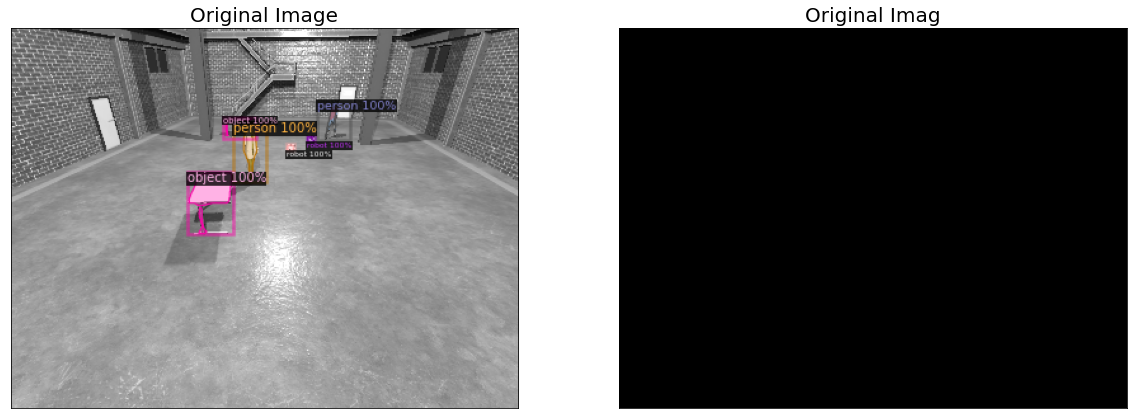

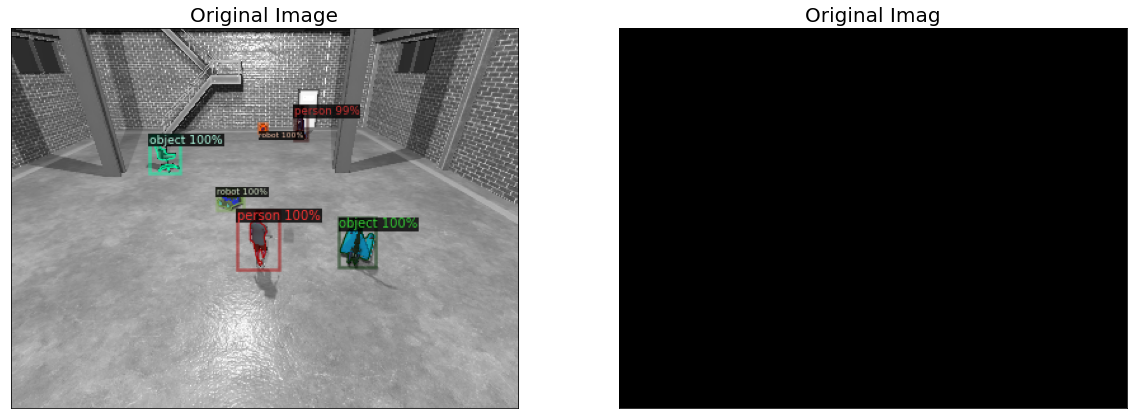

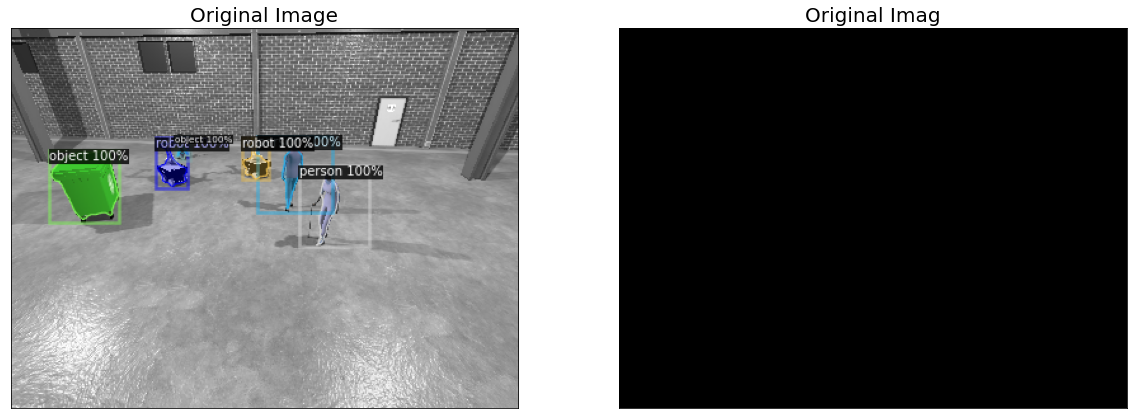

In [13]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = load_custom_dataset("valid")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=simulation_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualize(
        original_image = out.get_image()[:, :, ::-1],
        original_imag = Image.new('1', (800,600))
    )

uint8
uint8


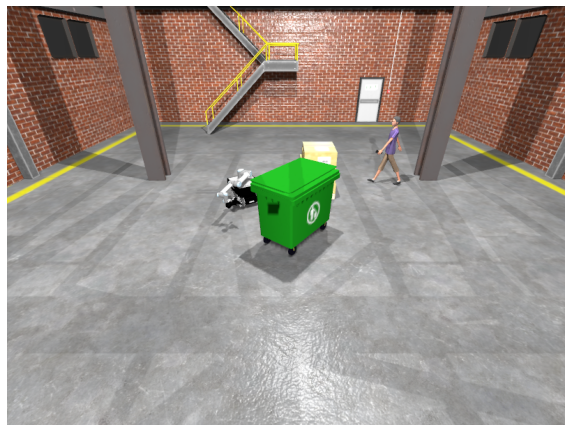

In [14]:
# Open the PNG image
image = cv2.cvtColor(cv2.imread("navigation.png"), cv2.COLOR_BGR2RGB)
print(image.dtype)

# Resize the image
#image = cv2.resize(image, (800, 600), interpolation=cv2.INTER_LINEAR)

print(image.dtype)
fig = plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


[06/30 23:54:49 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

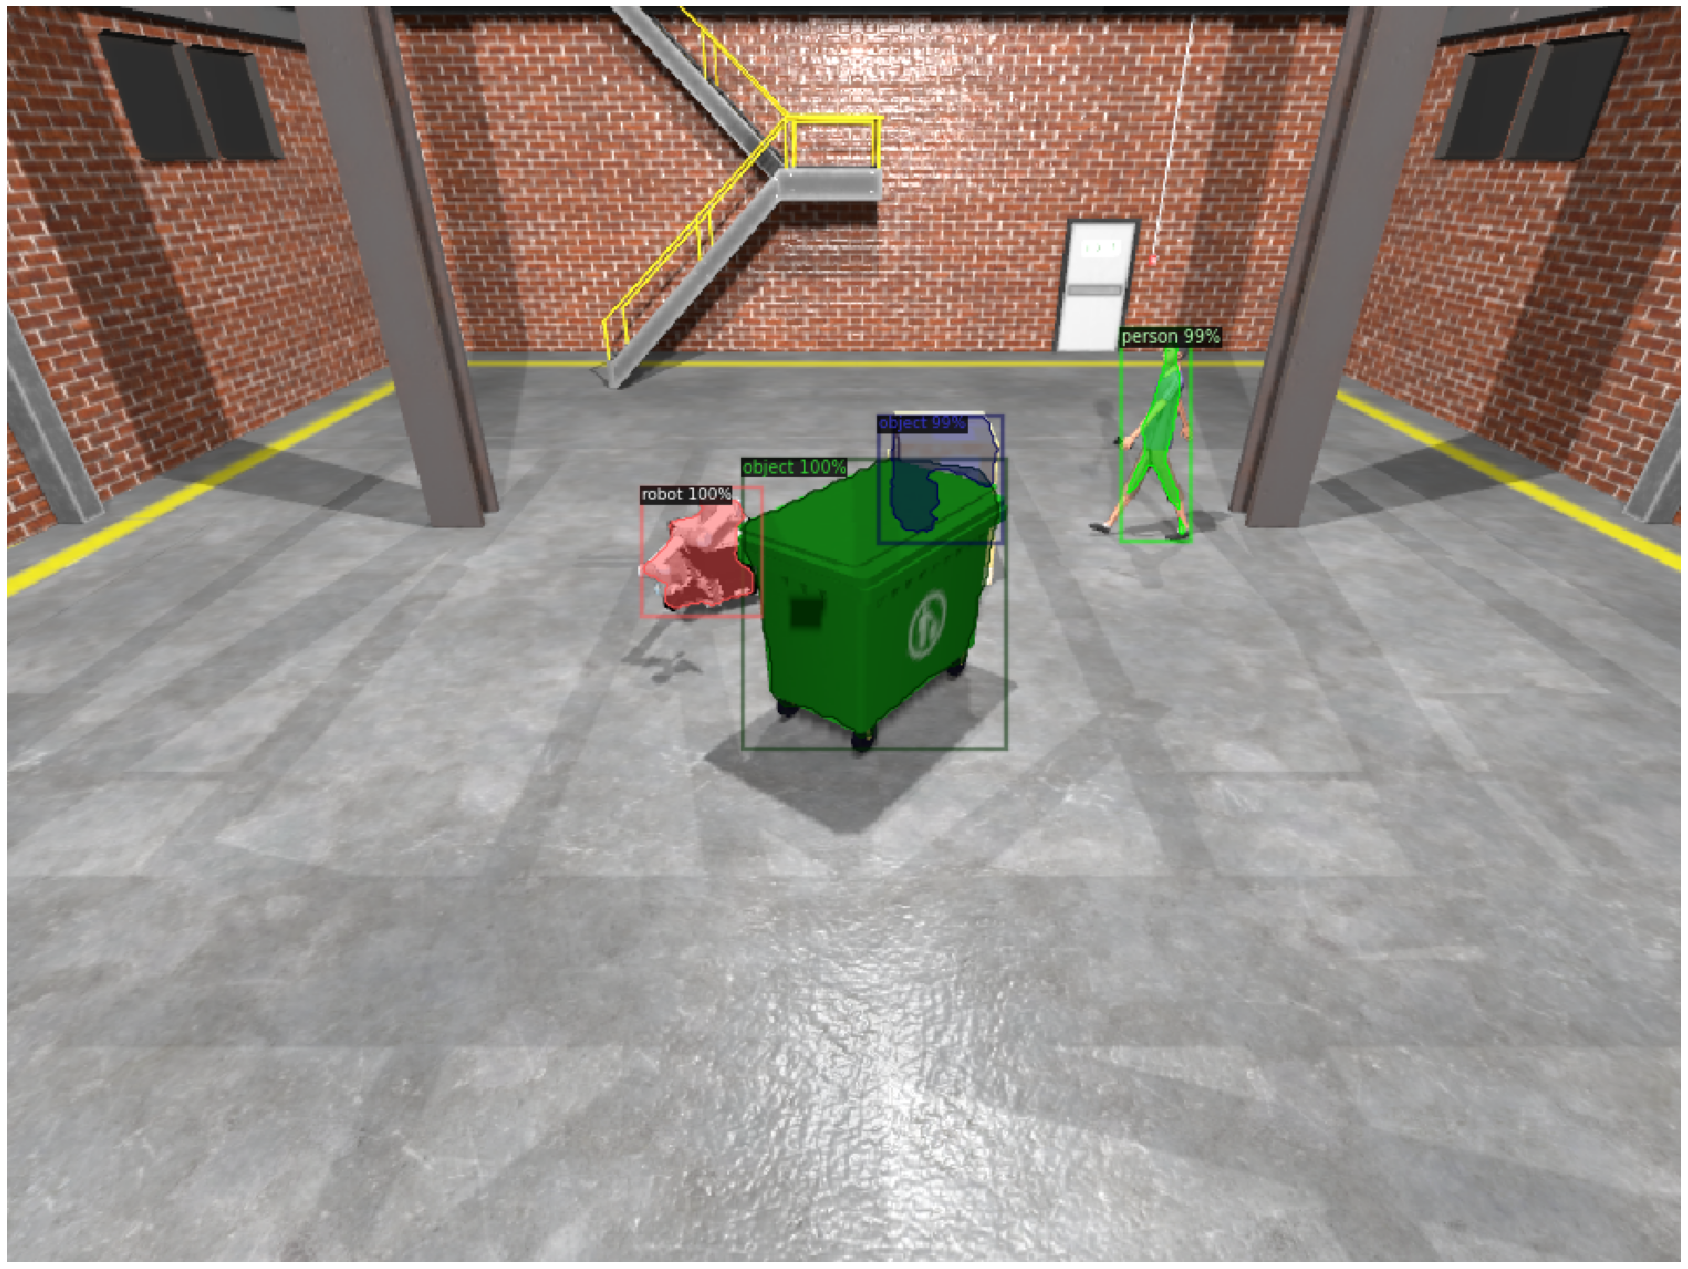

In [15]:
predictor = DefaultPredictor(cfg)
outputs = predictor(image)
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

#img = cv2.imread('input.jpg')
img = out.get_image()[:, :, ::-1]

fig = plt.figure(figsize=(30, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

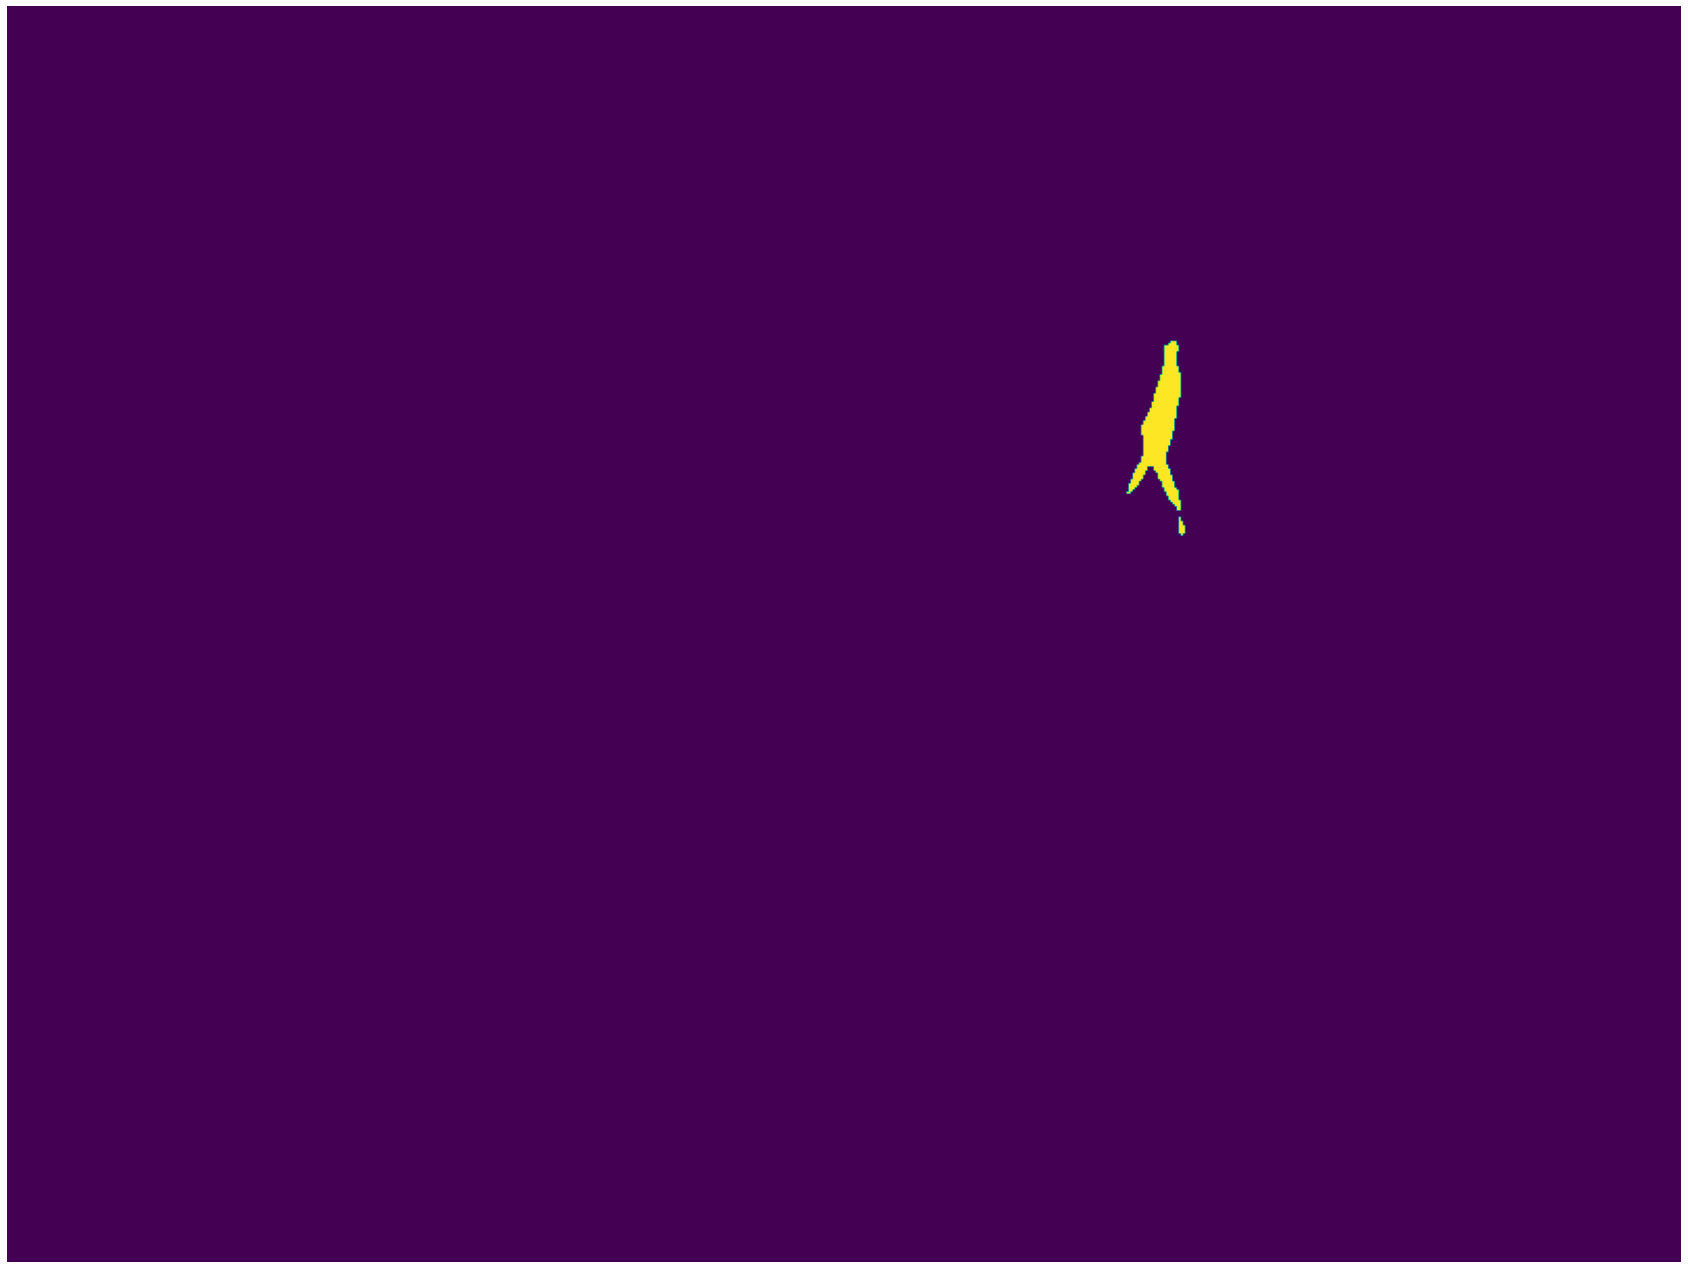

In [21]:
#PREDICTED MASKS
# Get the masks
masks = np.asarray(outputs["instances"].pred_masks.to("cpu"))
# 0, 2, 3
#mask_item1 = masks[1]
#mask_item2 = masks[2]
#mask_item3 = masks[3]
#merged_mask = np.logical_or(np.logical_or(mask_item1, mask_item2), mask_item3)
merged_mask = masks[3]

# Convert the merged mask to integer values (0 or 255)
merged_mask_int = merged_mask.astype(np.uint8) * 255

# Save the merged mask as a PNG file using OpenCV
cv2.imwrite('merged_mask.png', merged_mask_int)

fig = plt.figure(figsize=(30, 30))
plt.imshow(merged_mask)
plt.axis('off')
plt.show()



In [58]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [110]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("simulation_valid", output_dir="output")
val_loader = build_detection_test_loader(cfg, "simulation_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/03 23:46:16 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.


261it [00:02, 111.26it/s]

[03/03 23:46:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/03 23:46:18 d2.data.common]: Serializing 261 elements to byte tensors and concatenating them all ...
[03/03 23:46:18 d2.data.common]: Serialized dataset takes 0.62 MiB
[03/03 23:46:18 d2.evaluation.evaluator]: Start inference on 261 batches


[03/03 23:46:19 d2.evaluation.evaluator]: Inference done 11/261. Dataloading: 0.0007 s/iter. Inference: 0.0538 s/iter. Eval: 0.0030 s/iter. Total: 0.0575 s/iter. ETA=0:00:14
[03/03 23:46:24 d2.evaluation.evaluator]: Inference done 98/261. Dataloading: 0.0009 s/iter. Inference: 0.0539 s/iter. Eval: 0.0030 s/iter. Total: 0.0578 s/iter. ETA=0:00:09
[03/03 23:46:29 d2.evaluation.evaluator]: Inference done 184/261. Dataloading: 0.0009 s/iter. Inference: 0.0540 s/iter. Eval: 0.0030 s/iter. Total: 0.0580 s/iter. ETA=0:00:04
[03/03 23:46:34 d2.evaluation.evaluator]: Total inference time: 0:00:14.889864 (0.058164 s / iter per device, on 1 devices)
[03/03 23:46:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:13 (0.054075 s / iter per device, on 1 devices)
[03/03 23:46:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/03 23:46:34 d2.evaluation.coco_evaluation]: Saving results to output/coco_instances_results.json
[03/03 23:46:34 d2.evaluation.coco_e

IndexError: list index out of range

In [116]:
cfg.DATASETS.TEST = ("simulation_valid",)
model = DefaultTrainer.build_model(cfg)

test_datasets = ["simulation_valid"]
evaluator = COCOEvaluator("simulation_valid", output_dir="output")
trainer.test(cfg, model, evaluator)
print(metrics)


[03/03 23:58:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

261it [00:02, 115.31it/s]

[03/03 23:58:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/03 23:58:33 d2.data.common]: Serializing 261 elements to byte tensors and concatenating them all ...
[03/03 23:58:33 d2.data.common]: Serialized dataset takes 0.62 MiB
[03/03 23:58:33 d2.evaluation.evaluator]: Start inference on 261 batches


[03/03 23:58:34 d2.evaluation.evaluator]: Inference done 11/261. Dataloading: 0.0008 s/iter. Inference: 0.0503 s/iter. Eval: 0.0059 s/iter. Total: 0.0571 s/iter. ETA=0:00:14
[03/03 23:58:39 d2.evaluation.evaluator]: Inference done 100/261. Dataloading: 0.0010 s/iter. Inference: 0.0494 s/iter. Eval: 0.0058 s/iter. Total: 0.0563 s/iter. ETA=0:00:09
[03/03 23:58:44 d2.evaluation.evaluator]: Inference done 190/261. Dataloading: 0.0010 s/iter. Inference: 0.0494 s/iter. Eval: 0.0057 s/iter. Total: 0.0562 s/iter. ETA=0:00:03
[03/03 23:58:48 d2.evaluation.evaluator]: Total inference time: 0:00:14.416132 (0.056313 s / iter per device, on 1 devices)
[03/03 23:58:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.049416 s / iter per device, on 1 devices)
[03/03 23:58:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/03 23:58:48 d2.evaluation.coco_evaluation]: Saving results to output/coco_instances_results.json
[03/03 23:58:48 d2.evaluation.coco_

IndexError: list index out of range

In [ ]:
import numpy as np
from skimage import measure

def binary_mask_to_polygon(binary_mask):
    # Convert the binary mask to a label mask
    label_mask = measure.label(binary_mask)
    
    # Extract the regions from the label mask
    regions = measure.regionprops(label_mask)
    
    # Convert each region to a polygon
    def region2polygon(region):
        contour = np.flip(region.coords, axis=1)
        return contour.reshape(-1).tolist()
        
    polygons = [region2polygon(region) for region in regions]
    
    return polygons

In [114]:
print(cfg)

CUDA_LAUNCH_BLOCKING: 1
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 1
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: 
  TRAIN: ('simulation_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['